# imports

In [7]:
import nni
import numpy as np
import skimage
import torch
import nni.retiarii.nn.pytorch as nn

import lightning.pytorch as pl
from lightning.pytorch import LightningModule, Trainer   
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.utilities.types import STEP_OUTPUT # change to lightning.pytorch.utilities.types

from skimage.metrics import peak_signal_noise_ratio as skimage_psnr

from torch import optim, tensor, zeros_like
from typing import Any, Optional

from darts.common_utils import *
from darts.early_stop import MSE
from darts.noises import add_selected_noise
from darts.phantom import generate_phantom

from torch.utils.data import Dataset
from nni.retiarii.evaluator.pytorch.lightning import DataLoader

class SimpleAutoencoder(torch.nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3, stride=2, padding=1),
            torch.nn.ReLU(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# build in early stop

In [45]:

class SingleImageDataset(Dataset):
    def __init__(self, image, num_iter):
        self.image = image
        self.num_iter = num_iter

    def __len__(self):
        return self.num_iter

    def __getitem__(self, index):
        # Always return the same image (and maybe a noise tensor or other information if necessary??)
        return self.image

class LightningEval(LightningModule):
    def __init__(self, model_cls, phantom=None, buffer_size=100, num_iter=50,
                lr=0.00005, noise_type='gaussian', noise_factor=0.15, resolution=6, 
                n_channels=1, reg_noise_std_val=1./30.):
        super(LightningEval, self).__init__()

        # input
        self.phantom = phantom

        # Model
        self.net = model_cls.to(self.device)

        # Loss
        self.criterion = nn.MSELoss().to(self.device)
        
        # Hyperparameters / Inputs
        self.buffer_size = buffer_size
        self.num_iter = num_iter
        self.lr = lr
        self.noise_type = noise_type
        self.noise_factor = noise_factor
        self.resolution = resolution
        self.n_channels = n_channels
        self.reg_noise_std = tensor(reg_noise_std_val)

        # adjusting input
        if self.phantom is None:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor)
        else:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor, input_img_np=self.phantom)
        self.net_input = get_noise(input_depth=1, spatial_size=self.img_np.shape[1], noise_type=self.noise_type)
        
        # History and early stopper
        self.loss_history = []
        self.variance_history = []
        self.img_collection = []
        
    def forward(self, net_input):
        net_input_perturbed = net_input + zeros_like(net_input).normal_(std=self.reg_noise_std)
        return self.net(net_input_perturbed)
    
    def training_step(self, batch, batch_idx):
        """
        Deep Image Prior

        training here follows closely from the following two repos: 
            - the deep image prior repo
            - a DIP early stopping repo (Lighting has early stopping functionality so this blends the two)
        """        

        r_img_torch = self.forward(self.net_input)
        r_img_np = torch_to_np(r_img_torch)

        # update loss and loss history
        total_loss = self.criterion(r_img_torch, self.img_noisy_torch)
        self.loss_history.append(total_loss.item())
        self.logger.log_metrics({'loss': total_loss.item()})

        # Using global_step to count iterations
        iterator = self.global_step

        # update img collection
        r_img_np = r_img_np.reshape(-1)
        self.update_img_collection(r_img_np)
        img_collection = self.get_img_collection()

        # if len(img_collection) == self.buffer_size:
        if len(img_collection) >= self.buffer_size // 2:

            # update variance and var history
            ave_img = np.mean(img_collection, axis=0)
            variance = [MSE(ave_img, tmp) for tmp in img_collection]
            self.cur_var = np.mean(variance)
            self.variance_history.append(self.cur_var)

            # update log
            self.latest_loss = total_loss.item()
            self.log('variance', self.cur_var)
            self.log('loss', self.latest_loss)
            nni.report_intermediate_result({'Iteration':iterator,'variance':self.cur_var, 'loss': self.latest_loss})

        return {"loss": total_loss}

    def configure_optimizers(self):
        """
        Basic Adam Optimizer
        """
        optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        return optimizer
    
    def train_dataloader(self):
        """
        Dummy DataLoader that returns nothing but makes PyTorch Lightning's training loop work
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    def on_train_start(self):
        """
        Move all tensors to the GPU to begin training
        """
        self.net.to(self.device)
        self.net_input = self.net_input.to(self.device)
        self.img_noisy_torch = self.img_noisy_torch.to(self.device)
        self.reg_noise_std = self.reg_noise_std.to(self.device)

    def on_train_end(self, **kwargs: Any):
        """
        Report final PSNR to NNI and display the results
        """

        # final log
        # self.logger.log_metrics({'variance':self.cur_var, 'loss': self.latest_loss})
        nni.report_final_result({'variance':self.cur_var, 'loss': self.latest_loss})

        # plot images to see results
        denoised_img = self.forward(self.net_input).detach().cpu().squeeze().numpy()
        
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))

        ax[0].imshow(self.img_np.squeeze(), cmap='gray')
        ax[0].set_title("Original Image")
        ax[0].axis('off')

        ax[1].imshow(denoised_img, cmap='gray')
        ax[1].set_title("Denoised Image")
        ax[1].axis('off')

        ax[2].imshow(self.img_noisy_torch.detach().cpu().squeeze().numpy(), cmap='gray')
        ax[2].set_title("Noisy Image")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

    def update_img_collection(self, cur_img):
        self.img_collection.append(cur_img)
        if len(self.img_collection) > self.buffer_size:
            self.img_collection.pop(0)

    def get_img_collection(self):
        return self.img_collection

    def preprocess_image(self, resolution, noise_type, noise_factor, input_img_np=None):
        """
        Generates an image (or takes an input phantom), adds noise, and converts it to both numpy and torch tensors.

        Args:
        - resolution (int): Resolution for the phantom image.
        - noise_type (str): Type of noise to add.
        - noise_factor (float): Noise factor.
        - input_img_np (numpy.ndarray, optional): Input raw image in numpy format. If not provided, a new image will be generated.

        Returns:
        - img_np (numpy.ndarray): Original image in numpy format.
        - img_noisy_np (numpy.ndarray): Noisy image in numpy format.
        - img_torch (torch.Tensor): Original image in torch tensor format.
        - img_noisy_torch (torch.Tensor): Noisy image in torch tensor format.
        """
        if input_img_np is None:
            raw_img_np = generate_phantom(resolution=resolution) # 1x64x64 np array
        else:
            raw_img_np = input_img_np.copy() # 1x64x64 np array
            
        img_np = raw_img_np.copy() # 1x64x64 np array
        img_torch = torch.tensor(raw_img_np, dtype=torch.float32).unsqueeze(0) # 1x1x64x64 torch tensor
        img_noisy_torch = add_selected_noise(img_torch, noise_type=noise_type, noise_factor=noise_factor) # 1x1x64x64 torch tensor
        img_noisy_np = img_noisy_torch.squeeze(0).numpy() # 1x64x64 np array
        
        return img_np, img_noisy_np, img_torch, img_noisy_torch
    
    def validation_step(self, trainer, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
        # if self.buffer_size == len(self.img_collection):
        #     self._run_early_stopping_check(trainer)
        pass

    def test_step(self, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
        pass
    
class MyEarlyStopping(EarlyStopping):
    def on_valdiation_step(self, trainer, pl_module):
        if self.buffer_size == len(self.img_collection):
            self._run_early_stopping_check(trainer)
        pass

    def on_validation_end(self, trainer, pl_module):
        # override this to disable early stopping at the end of val loop
        pass

    def on_train_end(self, trainer, pl_module):
        # instead, do it at the end of training loop
        self._run_early_stopping_check(trainer)

Using cache found in C:\Users\thesis/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | net       | UNet    | 31.0 M
1 | criterion | MSELoss | 0     
--------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.146   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[2023-08-17 15:26:35] Intermediate result: {"Iteration": 49, "variance": 0.008880084864795208, "loss": 0.089786097407341}  (Index 41961)


Metric variance improved. New best score: 0.009


[2023-08-17 15:26:37] Intermediate result: {"Iteration": 50, "variance": 0.009014189261577878, "loss": 0.08810018002986908}  (Index 41962)
[2023-08-17 15:26:37] Intermediate result: {"Iteration": 51, "variance": 0.009148731290434416, "loss": 0.08653983473777771}  (Index 41963)
[2023-08-17 15:26:37] Intermediate result: {"Iteration": 52, "variance": 0.009288057465246826, "loss": 0.08507205545902252}  (Index 41964)
[2023-08-17 15:26:37] Intermediate result: {"Iteration": 53, "variance": 0.009431203309860494, "loss": 0.08336201310157776}  (Index 41965)
[2023-08-17 15:26:37] Intermediate result: {"Iteration": 54, "variance": 0.009567128511315042, "loss": 0.08116976171731949}  (Index 41966)
[2023-08-17 15:26:37] Intermediate result: {"Iteration": 55, "variance": 0.009690775236647044, "loss": 0.07841697335243225}  (Index 41967)
[2023-08-17 15:26:37] Intermediate result: {"Iteration": 56, "variance": 0.00989452939840001, "loss": 0.08315449953079224}  (Index 41968)
[2023-08-17 15:26:38] Interm

Metric variance improved by 0.005 >= min_delta = 0. New best score: 0.004


[2023-08-17 15:26:46] Intermediate result: {"Iteration": 150, "variance": 0.00400016040308401, "loss": 0.0377981960773468}  (Index 42062)
[2023-08-17 15:26:46] Intermediate result: {"Iteration": 151, "variance": 0.003895694063976407, "loss": 0.037666771560907364}  (Index 42063)
[2023-08-17 15:26:46] Intermediate result: {"Iteration": 152, "variance": 0.003786636566510424, "loss": 0.0374942310154438}  (Index 42064)
[2023-08-17 15:26:46] Intermediate result: {"Iteration": 153, "variance": 0.0036800103168934586, "loss": 0.03734665736556053}  (Index 42065)
[2023-08-17 15:26:46] Intermediate result: {"Iteration": 154, "variance": 0.003580659587169066, "loss": 0.03722890093922615}  (Index 42066)
[2023-08-17 15:26:46] Intermediate result: {"Iteration": 155, "variance": 0.0034976917773019522, "loss": 0.03721264377236366}  (Index 42067)
[2023-08-17 15:26:46] Intermediate result: {"Iteration": 156, "variance": 0.003359024825040251, "loss": 0.03706381469964981}  (Index 42068)
[2023-08-17 15:26:46

Metric variance improved by 0.003 >= min_delta = 0. New best score: 0.001


[2023-08-17 15:26:50] Intermediate result: {"Iteration": 200, "variance": 0.001375932379742153, "loss": 0.03187618777155876}  (Index 42112)
[2023-08-17 15:26:50] Intermediate result: {"Iteration": 201, "variance": 0.0013478288642363623, "loss": 0.03168606013059616}  (Index 42113)
[2023-08-17 15:26:50] Intermediate result: {"Iteration": 202, "variance": 0.001319727583322674, "loss": 0.0316842719912529}  (Index 42114)
[2023-08-17 15:26:50] Intermediate result: {"Iteration": 203, "variance": 0.001292453445494175, "loss": 0.031509727239608765}  (Index 42115)
[2023-08-17 15:26:50] Intermediate result: {"Iteration": 204, "variance": 0.00126788551453501, "loss": 0.03139747679233551}  (Index 42116)
[2023-08-17 15:26:50] Intermediate result: {"Iteration": 205, "variance": 0.0012427494174335153, "loss": 0.0313611701130867}  (Index 42117)
[2023-08-17 15:26:50] Intermediate result: {"Iteration": 206, "variance": 0.0012190339824883268, "loss": 0.031123515218496323}  (Index 42118)
[2023-08-17 15:26:

Metric variance improved by 0.001 >= min_delta = 0. New best score: 0.001


[2023-08-17 15:26:54] Intermediate result: {"Iteration": 250, "variance": 0.0006335628381930291, "loss": 0.027105487883090973}  (Index 42162)
[2023-08-17 15:26:54] Intermediate result: {"Iteration": 251, "variance": 0.0006266543720266782, "loss": 0.02704988233745098}  (Index 42163)
[2023-08-17 15:26:54] Intermediate result: {"Iteration": 252, "variance": 0.0006201167323160916, "loss": 0.02693122625350952}  (Index 42164)
[2023-08-17 15:26:54] Intermediate result: {"Iteration": 253, "variance": 0.0006139521603472531, "loss": 0.026890933513641357}  (Index 42165)
[2023-08-17 15:26:54] Intermediate result: {"Iteration": 254, "variance": 0.0006079794192919508, "loss": 0.026801960542798042}  (Index 42166)
[2023-08-17 15:26:54] Intermediate result: {"Iteration": 255, "variance": 0.0006012224944424815, "loss": 0.02676752582192421}  (Index 42167)
[2023-08-17 15:26:54] Intermediate result: {"Iteration": 256, "variance": 0.0005949960093130358, "loss": 0.026640649884939194}  (Index 42168)
[2023-08-

Metric variance improved by 0.000 >= min_delta = 0. New best score: 0.000


[2023-08-17 15:26:58] Intermediate result: {"Iteration": 300, "variance": 0.0003600578018813394, "loss": 0.024270109832286835}  (Index 42212)
[2023-08-17 15:26:58] Intermediate result: {"Iteration": 301, "variance": 0.0003562273157876916, "loss": 0.024224471300840378}  (Index 42213)
[2023-08-17 15:26:58] Intermediate result: {"Iteration": 302, "variance": 0.0003521408783853985, "loss": 0.02423699200153351}  (Index 42214)
[2023-08-17 15:26:58] Intermediate result: {"Iteration": 303, "variance": 0.0003483731819142122, "loss": 0.024190010502934456}  (Index 42215)
[2023-08-17 15:26:59] Intermediate result: {"Iteration": 304, "variance": 0.0003443938647978939, "loss": 0.02418534643948078}  (Index 42216)
[2023-08-17 15:26:59] Intermediate result: {"Iteration": 305, "variance": 0.0003409584818291478, "loss": 0.024126678705215454}  (Index 42217)
[2023-08-17 15:26:59] Intermediate result: {"Iteration": 306, "variance": 0.00033760146048734897, "loss": 0.024116002023220062}  (Index 42218)
[2023-0

Metric variance improved by 0.000 >= min_delta = 0. New best score: 0.000


[2023-08-17 15:27:03] Intermediate result: {"Iteration": 350, "variance": 0.0003192723536631092, "loss": 0.022307204082608223}  (Index 42262)
[2023-08-17 15:27:03] Intermediate result: {"Iteration": 351, "variance": 0.0003239348369243089, "loss": 0.02234337292611599}  (Index 42263)
[2023-08-17 15:27:03] Intermediate result: {"Iteration": 352, "variance": 0.0003285530787252355, "loss": 0.022239351645112038}  (Index 42264)
[2023-08-17 15:27:03] Intermediate result: {"Iteration": 353, "variance": 0.00033287073310930284, "loss": 0.022220149636268616}  (Index 42265)
[2023-08-17 15:27:03] Intermediate result: {"Iteration": 354, "variance": 0.00033693701116135346, "loss": 0.022148340940475464}  (Index 42266)
[2023-08-17 15:27:03] Intermediate result: {"Iteration": 355, "variance": 0.00034089048684109, "loss": 0.022115429863333702}  (Index 42267)
[2023-08-17 15:27:03] Intermediate result: {"Iteration": 356, "variance": 0.0003443418227834627, "loss": 0.02208024263381958}  (Index 42268)
[2023-08

Metric variance improved by 0.000 >= min_delta = 0. New best score: 0.000


[2023-08-17 15:27:11] Intermediate result: {"Iteration": 450, "variance": 0.0001591202666895697, "loss": 0.019815877079963684}  (Index 42362)
[2023-08-17 15:27:11] Intermediate result: {"Iteration": 451, "variance": 0.00015765344258397818, "loss": 0.019778598099946976}  (Index 42363)
[2023-08-17 15:27:11] Intermediate result: {"Iteration": 452, "variance": 0.00015677898190915584, "loss": 0.019754324108362198}  (Index 42364)
[2023-08-17 15:27:11] Intermediate result: {"Iteration": 453, "variance": 0.00015599716534779872, "loss": 0.019717495888471603}  (Index 42365)
[2023-08-17 15:27:11] Intermediate result: {"Iteration": 454, "variance": 0.00015524216680205428, "loss": 0.01971147581934929}  (Index 42366)
[2023-08-17 15:27:12] Intermediate result: {"Iteration": 455, "variance": 0.00015462345108971932, "loss": 0.019685596227645874}  (Index 42367)
[2023-08-17 15:27:12] Intermediate result: {"Iteration": 456, "variance": 0.00015423493096022867, "loss": 0.019691573455929756}  (Index 42368)
[

Metric variance improved by 0.000 >= min_delta = 0. New best score: 0.000


[2023-08-17 15:27:16] Intermediate result: {"Iteration": 500, "variance": 0.00015136040332436096, "loss": 0.018836453557014465}  (Index 42412)
[2023-08-17 15:27:16] Intermediate result: {"Iteration": 501, "variance": 0.00015137541602598504, "loss": 0.018817299976944923}  (Index 42413)
[2023-08-17 15:27:16] Intermediate result: {"Iteration": 502, "variance": 0.0001511610516172368, "loss": 0.018827665597200394}  (Index 42414)
[2023-08-17 15:27:16] Intermediate result: {"Iteration": 503, "variance": 0.00015078518881637138, "loss": 0.018772786483168602}  (Index 42415)
[2023-08-17 15:27:16] Intermediate result: {"Iteration": 504, "variance": 0.0001504410796769662, "loss": 0.018753625452518463}  (Index 42416)
[2023-08-17 15:27:16] Intermediate result: {"Iteration": 505, "variance": 0.0001503435301128775, "loss": 0.018752222880721092}  (Index 42417)
[2023-08-17 15:27:16] Intermediate result: {"Iteration": 506, "variance": 0.00015028526162495835, "loss": 0.01874173805117607}  (Index 42418)
[20

Metric variance improved by 0.000 >= min_delta = 0. New best score: 0.000


[2023-08-17 15:27:20] Intermediate result: {"Iteration": 550, "variance": 0.00013591857932624408, "loss": 0.01797931268811226}  (Index 42462)
[2023-08-17 15:27:20] Intermediate result: {"Iteration": 551, "variance": 0.00013579396145360078, "loss": 0.017978161573410034}  (Index 42463)
[2023-08-17 15:27:20] Intermediate result: {"Iteration": 552, "variance": 0.00013573960692156106, "loss": 0.01794968917965889}  (Index 42464)
[2023-08-17 15:27:20] Intermediate result: {"Iteration": 553, "variance": 0.0001358482784416992, "loss": 0.01795489341020584}  (Index 42465)
[2023-08-17 15:27:20] Intermediate result: {"Iteration": 554, "variance": 0.0001360100798046915, "loss": 0.017949547618627548}  (Index 42466)
[2023-08-17 15:27:20] Intermediate result: {"Iteration": 555, "variance": 0.00013599643803900109, "loss": 0.017924241721630096}  (Index 42467)
[2023-08-17 15:27:20] Intermediate result: {"Iteration": 556, "variance": 0.00013591096249001566, "loss": 0.017879314720630646}  (Index 42468)
[202

Monitored metric variance did not improve in the last 6 records. Best score: 0.000. Signaling Trainer to stop.


[2023-08-17 15:27:45] Final result: {"variance": 0.00016029344755224883, "loss": 0.014038117602467537}


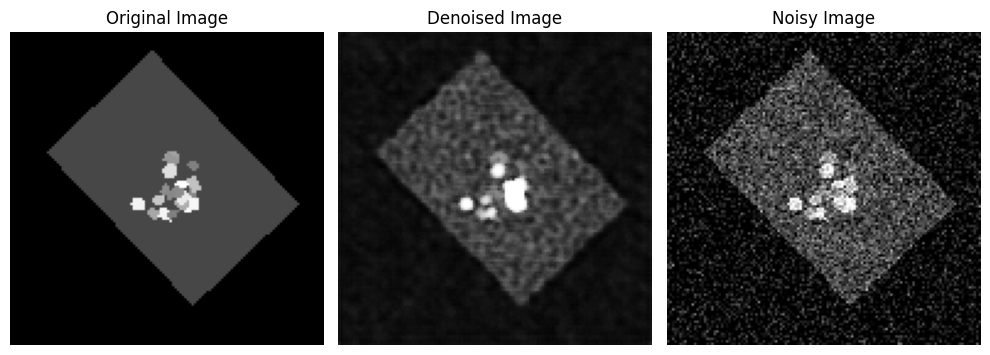

In [50]:
# input image (phantom)
resolution = 7
phantom = generate_phantom(resolution=resolution)

# model
# model = SimpleAutoencoder()
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=64, pretrained=False)

# early stopper
custom_early_stopping = MyEarlyStopping(
    monitor="variance", 
    mode="min", 
    patience=3, 
    verbose=True,
    min_delta=0
    )

basic_early_stopping = EarlyStopping(
    monitor="variance", 
    mode="min", 
    patience=6, 
    verbose=True,
    min_delta=0
    )

# Create the lightning module
module = LightningEval(
                model, 
                phantom=phantom, 
                buffer_size=100,
                num_iter=50,
                lr=0.00005, 
                noise_type='gaussian', 
                noise_factor=0.15, 
                resolution=resolution, 
                )

# Create a PyTorch Lightning trainer
# trainer = Trainer(max_epochs=5)
trainer = Trainer(
            callbacks=[basic_early_stopping],
            max_epochs=100, # (max_epochs)*(num_iter) = (Total Iterations) ---> 85 * 50 = 4250 iterations
            # check_val_every_n_epoch=1 # check validation every epoch (num_iter) ---> check validation every 50 iterations
            )

# # Train the model
trainer.fit(module)